

*   Will do the Target encoding
* Scaling the data
*   Handle Imbalanced Data In XGBoost Using scale_pos_weight In Python



# **Basic Model - Using Cleaned Dataset**

In [1]:
!pip install matplotlib

In [2]:

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:


from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns',None)
import re
from sklearn.model_selection import train_test_split, cross_val_score
import math
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [5]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score

from sklearn.metrics import f1_score


In [6]:

data = pd.read_csv('/content/drive/MyDrive/NUS_SEM_2_(Jan2024_May2024)/Hands on Applied Analytics/Project/Loan Dfault Project/Data/cleaned_data.csv')

In [7]:
data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
0,10000.0,36,11.44,329.48,B4,10.0,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,26.24,1990,16.0,0.0,36369.0,41.8,25.0,Whole Funded,INDIVIDUAL,0.0,0.0,22690
1,8000.0,36,11.99,265.68,B5,4.0,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,22.05,2004,17.0,0.0,20131.0,53.3,27.0,Fractional Funded,INDIVIDUAL,3.0,0.0,5113
2,15600.0,36,10.49,506.97,B3,0.0,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,12.79,2007,13.0,0.0,11987.0,92.2,26.0,Fractional Funded,INDIVIDUAL,0.0,0.0,5113
3,7200.0,36,6.49,220.65,A2,6.0,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,2.60,2006,6.0,0.0,5472.0,21.5,13.0,Fractional Funded,INDIVIDUAL,0.0,0.0,813
4,24375.0,60,17.27,609.33,C5,9.0,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,33.95,1999,13.0,0.0,24584.0,69.8,43.0,Fractional Funded,INDIVIDUAL,1.0,0.0,11650


In [7]:
print(f"The Length of the data: {data.shape}")

The Length of the data: (340775, 24)


In [8]:
data[data["loan_status"] == "Fully Paid"].shape[0]


273507

In [9]:
data[data["loan_status"] == "Charged Off"].shape[0]

67268

In [10]:
data.shape

(340775, 24)

## Feature Engineering

In [8]:
data =data.drop(['issue_d', 'earliest_cr_line'], axis = 1)

Convert target variable to 0/1 indicator

In [9]:
# One hot encoding for Y
class_mapping = {"Fully Paid":0, "Charged Off":1}
data['loan_status']=data['loan_status'].map(class_mapping)

In [10]:
data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
0,10000.0,36,11.44,329.48,B4,10.0,RENT,117000.0,Not Verified,0,vacation,26.24,16.0,0.0,36369.0,41.8,25.0,Whole Funded,INDIVIDUAL,0.0,0.0,22690
1,8000.0,36,11.99,265.68,B5,4.0,MORTGAGE,65000.0,Not Verified,0,debt_consolidation,22.05,17.0,0.0,20131.0,53.3,27.0,Fractional Funded,INDIVIDUAL,3.0,0.0,5113
2,15600.0,36,10.49,506.97,B3,0.0,RENT,43057.0,Source Verified,0,credit_card,12.79,13.0,0.0,11987.0,92.2,26.0,Fractional Funded,INDIVIDUAL,0.0,0.0,5113
3,7200.0,36,6.49,220.65,A2,6.0,RENT,54000.0,Not Verified,0,credit_card,2.60,6.0,0.0,5472.0,21.5,13.0,Fractional Funded,INDIVIDUAL,0.0,0.0,813
4,24375.0,60,17.27,609.33,C5,9.0,MORTGAGE,55000.0,Verified,1,credit_card,33.95,13.0,0.0,24584.0,69.8,43.0,Fractional Funded,INDIVIDUAL,1.0,0.0,11650


###  Categorical Variables

In [11]:
dummy_list= [column for column in data.columns if data[column].dtype == object]
print(dummy_list)

['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']


In [12]:
dummy_list_new = ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']

In [13]:
data[dummy_list_new].isnull().any()

sub_grade              False
home_ownership         False
verification_status    False
purpose                False
initial_list_status    False
application_type       False
dtype: bool

In [14]:
data = pd.get_dummies(data, columns=dummy_list_new, drop_first=True)

In [15]:
data.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,zip_code,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_Whole Funded,application_type_INDIVIDUAL,application_type_JOINT
0,10000.0,36,11.44,329.48,10.0,117000.0,0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,22690,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False
1,8000.0,36,11.99,265.68,4.0,65000.0,0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,5113,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,15600.0,36,10.49,506.97,0.0,43057.0,0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,5113,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,7200.0,36,6.49,220.65,6.0,54000.0,0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,813,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,24375.0,60,17.27,609.33,9.0,55000.0,1,33.95,13.0,0.0,24584.0,69.8,43.0,1.0,0.0,11650,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [25]:
data.shape

(340775, 71)

## Train/Test Split

In [ ]:


# data['issue_d'] = pd.to_datetime(data['issue_d'])

In [ ]:
# data['issue_d'].sample()


721030   2014-07-01
Name: issue_d, dtype: datetime64[ns]

In [ ]:
# data['issue_d'].describe()

count                          1220092
mean     2015-07-29 07:38:52.399851520
min                2012-03-01 00:00:00
25%                2014-08-01 00:00:00
50%                2015-09-01 00:00:00
75%                2016-07-01 00:00:00
max                2018-12-01 00:00:00
Name: issue_d, dtype: object

There are 82 unique values. The first loans were issued in Jan 2012 and the last loans were issued in September 2018. The busiest month was Oct 2016, with 45410 loans funded in that month. Let's further check the distribution of loans funded per month.



Text(0.5, 1.0, 'Loans funded per Year')

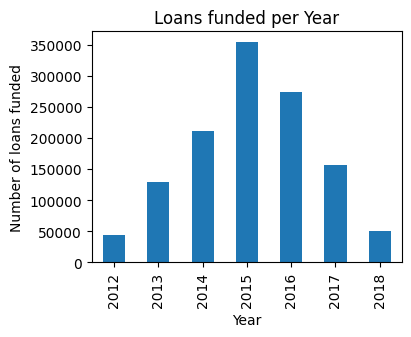

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,3))
# data['issue_d'].dt.year.value_counts().sort_index().plot.bar()
# plt.xlabel('Year')
# plt.ylabel('Number of loans funded')
# plt.title('Loans funded per Year')

nterestingly, the funded loans significantly increased since 2013, and continued through 2015.

We will split the train/test sample at 8:2.



Why is this useful?

The 80th percentile is often used for splitting your data into training and testing sets for machine learning tasks, particularly when dealing with time-series data like loan issue dates. Here's why:

Simulates Real-World Scenario:  Imagine your model predicts loan defaults. In reality, the model wouldn't have access to future loan information. Splitting at the 80th percentile creates a training set with historical data (loans issued before) and a testing set with loans issued later. This helps assess how well the model generalizes to unseen data, similar to how it would perform on future loans.

Preserves Temporal Trends:  Loan performance might change over time due to economic factors or LendingClub's practices. The training data with loans issued before the 80th percentile captures historical trends relevant to predicting future defaults. The model learns these trends to predict defaults in loans issued later (testing set).

Avoids Data Leakage:  If the model were trained on all data, including future loans (testing set), it might "cheat" by learning patterns specific to those loans. This would lead to overfitting, where the model performs well on the training data but poorly on unseen data (future loans). Splitting at the 80th percentile ensures the training data doesn't contain information from the testing set, preventing leakage.

In [ ]:
# data_train = data.loc[data['issue_d']  < data['issue_d'].quantile(0.8)]
# data_test =  data.loc[data['issue_d'] >= data['issue_d'].quantile(0.8)]

In [ ]:
# data['issue_d'].quantile(0.8)

In [16]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)

In [17]:
print('Number of loans in the partition:   ', data_train.shape[0] + data_test.shape[0])
print('Number of loans in the full dataset:', data.shape[0])

Number of loans in the partition:    340775
Number of loans in the full dataset: 340775


In [18]:
data_train.shape, data_test.shape

((228319, 71), (112456, 71))

summary statistics of the issue dates in the train/test sets.



Now separate the predictor variables from the target variable

In [19]:
X_train = data_train.drop(['loan_status'], axis=1)
y_train = data_train.loc[:, 'loan_status']

X_test = data_test.drop(['loan_status'], axis=1)
y_test = data_test['loan_status']

In [20]:
print("Shape of the training set: ", X_train.shape)

print("Shape of the test set: ", X_test.shape)

print("Percentage of classes in the training set:")

print(y_train.value_counts(normalize = True))

print("Percentage of classes in the test set:")

print(y_test.value_counts(normalize = True))

Shape of the training set:  (228319, 70)
Shape of the test set:  (112456, 70)
Percentage of classes in the training set:
loan_status
0    0.802509
1    0.197491
Name: proportion, dtype: float64
Percentage of classes in the test set:
loan_status
0    0.802794
1    0.197206
Name: proportion, dtype: float64


In [6]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [7]:


def ks_score(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    ks = max(tpr - fpr)
    return ks



In [8]:
def plot_precision_recall_curve(labels, pre_scores):

    average_precision = metrics.average_precision_score(labels, pre_scores)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = metrics.precision_recall_curve(labels, pre_scores)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### XG Boost using cleaned data

In [24]:
import time

In [31]:
from xgboost import XGBClassifier

# XGBoost
classifier_xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )

In [32]:
classifier_xgb.fit(X_train, y_train)
y_train_pred = classifier_xgb.predict(X_train)
y_test_pred = classifier_xgb.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 89.76%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.892312      0.941141  0.897573       0.916726       0.901955
recall          0.992097      0.513473  0.897573       0.752785       0.897573
f1-score        0.939563      0.664438  0.897573       0.802000       0.885228
support    183228.000000  45091.000000  0.897573  228319.000000  228319.000000
_______________________________________________
Confusion Matrix: 
 [[181780   1448]
 [ 21938  23153]]

Test Result:
Accuracy Score: 88.80%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.886021      0.904400  0.887956       0.895210       0.889645
recall         0.987461      0.482888  0.887956       0.735174       0.887956
f1-score       0.933995      0.629608  0.887956     

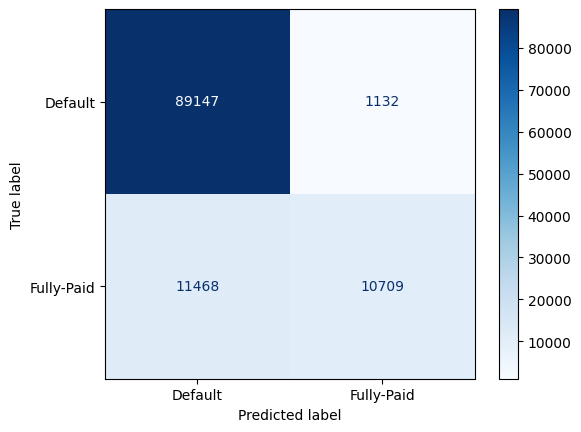

In [33]:
disp = ConfusionMatrixDisplay.from_estimator(
    classifier_xgb, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


In [34]:
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]

In [35]:

ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6088558175212646


Average precision-recall score: 0.78


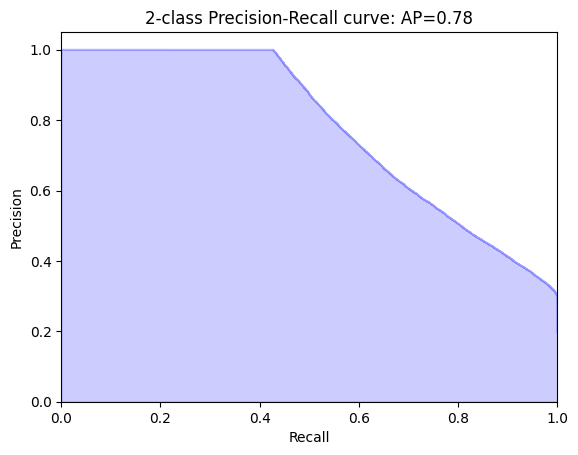

In [36]:

plot_precision_recall_curve(y_test,y_pred_prob)

In [ ]:
# start = time.time()
# from xgboost import XGBClassifier

# # XGBoost
# classifier_xgb = XGBClassifier()

# start = time.time()
# parameters = {

#     'min_child_weight':(300,500,800),
#     'learning_rate':(0.05, 0.1,0.3),
#     'min_split_loss':(0,0.01,0.1),
#     'max_depth':(2,6,8,10),
#     'lambda':(0.1,0.5,1)
# }


# Grid_XGB = GridSearchCV(XGBClassifier(),parameters, cv=5)
# Grid_XGB.fit(X_train, y_train)
# elapsed = time.time() - start
# print(elapsed)



# **Basic Model - Using Preprocessed Dataset**



Load the preprocessed Data

In [9]:
# Load the data
train_data = pd.read_csv("/content/drive/MyDrive/NUS_SEM_2_(Jan2024_May2024)/Hands on Applied Analytics/Project/Loan Dfault Project/Data/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/NUS_SEM_2_(Jan2024_May2024)/Hands on Applied Analytics/Project/Loan Dfault Project/Data/test.csv")

In [41]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,zip_code
0,7000.0,36,8.99,222.57,B1,RENT,154000.0,Source Verified,Fully Paid,credit_card,23.88,16.0,0.0,91725.0,62.2,48.0,INDIVIDUAL,2.0,5113
1,2000.0,36,11.53,65.99,B5,RENT,41600.0,Not Verified,Fully Paid,debt_consolidation,26.49,11.0,0.0,3541.0,20.1,16.0,INDIVIDUAL,0.0,22690
2,24000.0,60,12.39,538.61,C1,MORTGAGE,120000.0,Source Verified,Fully Paid,debt_consolidation,19.01,13.0,0.0,38065.0,79.0,34.0,INDIVIDUAL,1.0,48052
3,15575.0,60,17.57,391.87,D2,MORTGAGE,62000.0,Source Verified,Charged Off,debt_consolidation,26.06,9.0,0.0,15089.0,74.7,23.0,INDIVIDUAL,5.0,48052
4,12000.0,36,12.69,402.54,C2,RENT,36000.0,Source Verified,Charged Off,debt_consolidation,34.67,18.0,0.0,5681.0,38.6,28.0,INDIVIDUAL,0.0,86630


In [38]:
# test_data = test_data.drop('issue_d' , axis=1)
# train_data = train_data.drop('issue_d' , axis=1)

KeyError: "['issue_d'] not found in axis"

## Feature Engineering

Convert target variable to 0/1 indicator

In [10]:
# One hot encoding for Y
class_mapping = {"Fully Paid":0, "Charged Off":1}
train_data['loan_status']=train_data['loan_status'].map(class_mapping)
test_data['loan_status']=test_data['loan_status'].map(class_mapping)

## Encoding

In [11]:
categorical_columns = test_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type']

In [12]:
for column in categorical_columns:
    unique_values = test_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 14 unique values.
Column 'application_type' has 3 unique values.


##  One hot Encoding


In [13]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type', 'sub_grade', 'purpose' ]


In [14]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)
encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix={col: col for col in cat_columns_ohe})
encoded_combined_df.reset_index(drop=True, inplace=True)

In [15]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)

In [16]:
X_train = train_data.drop(['loan_status'], axis=1)
y_train = train_data.loc[:, 'loan_status']

X_test = test_data.drop(['loan_status'], axis=1)
y_test = test_data['loan_status']

In [17]:
X_test = X_test[X_train.columns]

In [18]:
X_test.tail()

,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,zip_code,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
112451,14000.0,60,14.46,329.11,66400.0,9.81,11.0,2.0,15181.0,77.5,54.0,0.0,48052,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
112452,10500.0,36,10.99,343.71,38000.0,13.99,16.0,0.0,3725.0,23.6,30.0,1.0,48052,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
112453,9600.0,36,15.61,335.67,55000.0,33.89,9.0,0.0,7389.0,40.6,12.0,0.0,5113,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
112454,24000.0,36,17.77,864.90,80000.0,13.35,8.0,0.0,18368.0,74.3,21.0,3.0,29597,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
112455,5000.0,36,9.99,161.32,46000.0,10.62,5.0,0.0,51149.0,61.6,28.0,2.0,5113,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [19]:
print("Shape of the training set: ", X_train.shape)

print("Shape of the test set: ", X_test.shape)

print("Percentage of classes in the training set:")

print(y_train.value_counts(normalize = True))

print("Percentage of classes in the test set:")

print(y_test.value_counts(normalize = True))

Shape of the training set:  (223591, 67)
Shape of the test set:  (112456, 67)
Percentage of classes in the training set:
loan_status
0    0.802242
1    0.197758
Name: proportion, dtype: float64
Percentage of classes in the test set:
loan_status
0    0.802794
1    0.197206
Name: proportion, dtype: float64


## XG Boost on pre processed one

In [ ]:
import time

In [54]:
from xgboost import XGBClassifier

# XGBoost
# classifier_xgb = XGBClassifier(eval_metric="aucpr")
classifier_xgb = XGBClassifier()

In [55]:
classifier_xgb.fit(X_train, y_train)
y_train_pred = classifier_xgb.predict(X_train)
y_test_pred = classifier_xgb.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 89.70%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.891700      0.941164  0.897013       0.916432       0.901482
recall          0.992123      0.511183  0.897013       0.751653       0.897013
f1-score        0.939235      0.662524  0.897013       0.800879       0.884513
support    179374.000000  44217.000000  0.897013  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[177961   1413]
 [ 21614  22603]]

Test Result:
Accuracy Score: 88.74%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.885669      0.901740   0.88736       0.893705       0.888838
recall         0.987118      0.481264   0.88736       0.734191       0.887360
f1-score       0.933646      0.627584   0.88736     

In [56]:
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]

In [57]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6082871081090853


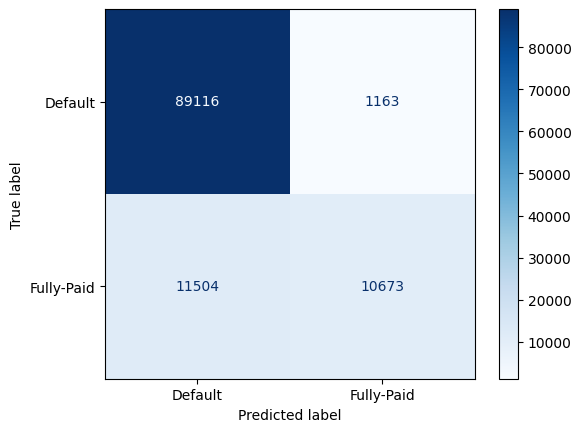

In [58]:
disp = ConfusionMatrixDisplay.from_estimator(
    classifier_xgb, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


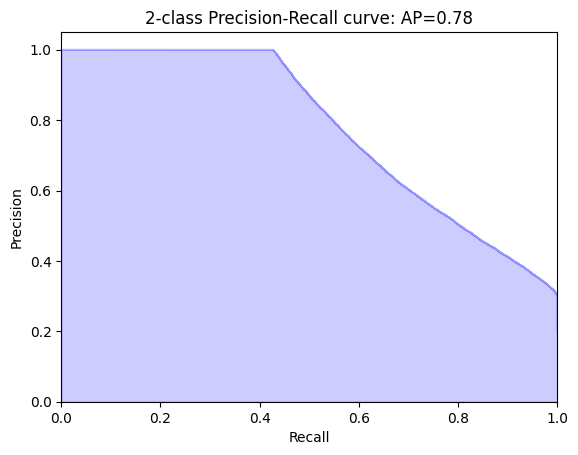

In [59]:
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

Average precision calculated here is the area under the precision-recall curve which is also called as average precision.

# Basic Model - Using Preprocessed Dataset,Imbalanced Data, Tuning,

## Feature Engineering

Convert target variable to 0/1 indicator

In [ ]:
# One hot encoding for Y
class_mapping = {"Fully Paid":0, "Charged Off":1}
train_data['loan_status']=train_data['loan_status'].map(class_mapping)
test_data['loan_status']=test_data['loan_status'].map(class_mapping)

## Encoding

In [ ]:
categorical_columns = test_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'application_type']

In [ ]:
for column in categorical_columns:
    unique_values = test_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 13 unique values.
Column 'addr_state' has 50 unique values.
Column 'application_type' has 2 unique values.


##  One hot Encoding


In [ ]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type','addr_state', 'sub_grade', 'purpose' ]


In [ ]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)
encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix={col: col for col in cat_columns_ohe})
encoded_combined_df.reset_index(drop=True, inplace=True)

In [ ]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)

In [ ]:
X_train = train_data.drop(['loan_status'], axis=1)
y_train = train_data.loc[:, 'loan_status']

X_test = test_data.drop(['loan_status'], axis=1)
y_test = test_data['loan_status']

In [60]:
print("Shape of the training set: ", X_train.shape)

print("Shape of the test set: ", X_test.shape)

print("Percentage of classes in the training set:")

print(y_train.value_counts(normalize = True))

print("Percentage of classes in the test set:")

print(y_test.value_counts(normalize = True))

Shape of the training set:  (223591, 67)
Shape of the test set:  (112456, 67)
Percentage of classes in the training set:
loan_status
0    0.802242
1    0.197758
Name: proportion, dtype: float64
Percentage of classes in the test set:
loan_status
0    0.802794
1    0.197206
Name: proportion, dtype: float64


In [61]:
X_test = X_test[X_train.columns]

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV


In [63]:
# Choose the type of classifier.

xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )


# Grid of parameters to choose from

parameters = {'max_depth':range(3,10,2),
            'min_child_weight':range(1,6,2),
            'learning_rate': [0.30000012],
            'max_bin':[256],
            'n_estimators':[100, 200]
             }


# Type of scoring used to compare parameter combinations

# scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search

xgb_model = RandomizedSearchCV(xgb, parameters, scoring = "f1_weighted", cv = 3)


#fit the Random Search on train dataset

xgb_model = xgb_model.fit(X_train, y_train)


# Set the clf to the best combination of parameters

xgb_estimator_tuned = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30000012,
              max_bin=256, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=4,
              num_parallel_tree=None, random_state=123, ...)

In [64]:
y_train_pred = xgb_estimator_tuned.predict(X_train)
y_test_pred = xgb_estimator_tuned.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 89.39%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.888669      0.938929  0.893918       0.913799       0.898609
recall          0.992050      0.495827  0.893918       0.743939       0.893918
f1-score        0.937518      0.648956  0.893918       0.793237       0.880453
support    179374.000000  44217.000000  0.893918  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[177948   1426]
 [ 22293  21924]]

Test Result:
Accuracy Score: 88.78%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.884999      0.912211  0.887805       0.898605       0.890365
recall         0.988724      0.476981  0.887805       0.732852       0.887805
f1-score       0.933990      0.626418  0.887805     

In [65]:
from sklearn.metrics import f1_score

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Weighted Score:", f1_weighted)

F1 Weighted Score: 0.8733352209123254


In [71]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [72]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6121976970018645


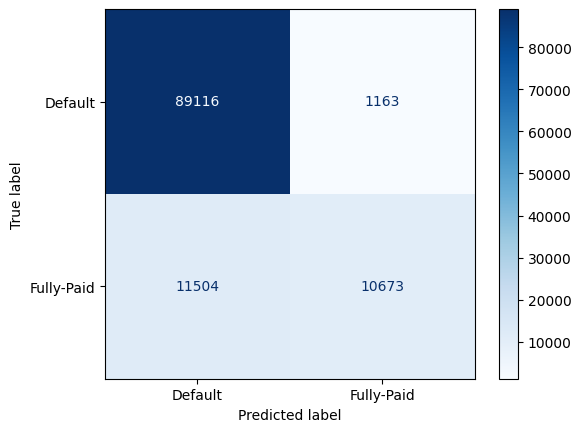

In [73]:
disp = ConfusionMatrixDisplay.from_estimator(
    classifier_xgb, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


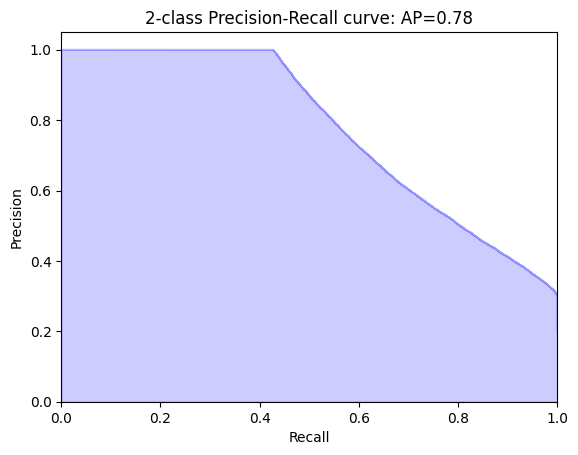

In [74]:
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

Average precision calculated here is the area under the precision-recall curve which is also called as average precision.

## Using Preprocessed Dataset, scale_pos_weight=Balanced, Before Tuning

In [20]:
# Calculate the scale_pos_weight using the square root transformation
scale_pos_weight = float(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

In [21]:

from xgboost import XGBClassifier

# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 83.33%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.956521      0.551132  0.833321       0.753827       0.876352
recall          0.829959      0.846959  0.833321       0.838459       0.833321
f1-score        0.888757      0.667748  0.833321       0.778253       0.845051
support    179374.000000  44217.000000  0.833321  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[148873  30501]
 [  6767  37450]]

Test Result:
Accuracy Score: 81.19%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.939556      0.515183  0.811926       0.727370       0.855867
recall         0.818374      0.785679  0.811926       0.802027       0.811926
f1-score       0.874788      0.622308  0.811926     

In [24]:
y_pred_prob = xgb_clf.predict_proba(X_test)[:,1]

In [26]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6049310216692724


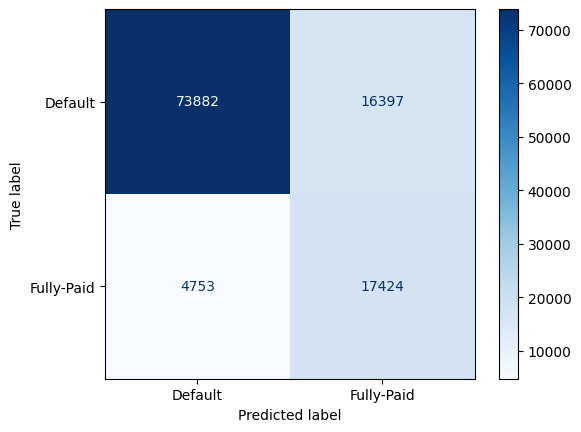

In [27]:
disp = ConfusionMatrixDisplay.from_estimator(
  xgb_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


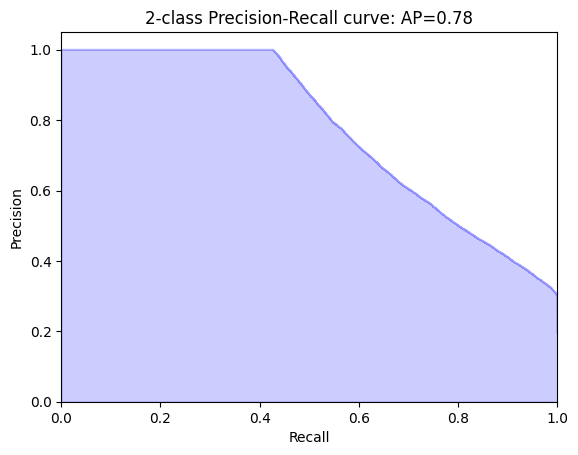

In [29]:
y_pred_prob = xgb_clf.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

# **Using Preprocessed Dataset, scale_pos_weight=Balanced, Tuning, F1 scorer**

In [30]:
# Calculate the scale_pos_weight using the square root transformation
scale_pos_weight = float(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

In [33]:
# Choose the type of classifier.

xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr",scale_pos_weight=scale_pos_weight )


# Grid of parameters to choose from

parameters = {'max_depth':range(3,10,2),
            'min_child_weight':range(1,6,2),
            'learning_rate': [0.30000012],
            'max_bin':[256],
            'n_estimators':[100, 200]
             }


# Type of scoring used to compare parameter combinations

scorer = metrics.make_scorer(f1_score, pos_label = 1)


# Run the grid search

xgb_model = RandomizedSearchCV(xgb, parameters, scoring = scorer, cv = 3)


#fit the Random Search on train dataset

xgb_model = xgb_model.fit(X_train, y_train)


# Set the clf to the best combination of parameters

xgb_estimator_tuned = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30000012,
              max_bin=256, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, random_state=123, ...)

In [34]:
y_train_pred = xgb_estimator_tuned.predict(X_train)
y_test_pred = xgb_estimator_tuned.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 94.75%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.992833      0.803521  0.947525       0.898177       0.955395
recall          0.941385      0.972431  0.947525       0.956908       0.947525
f1-score        0.966425      0.879944  0.947525       0.923184       0.949322
support    179374.000000  44217.000000  0.947525  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[168860  10514]
 [  1219  42998]]

Test Result:
Accuracy Score: 84.02%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.918134      0.581028   0.84024       0.749581       0.851655
recall         0.879407      0.680795   0.84024       0.780101       0.840240
f1-score       0.898354      0.626967   0.84024     

In [ ]:
# from sklearn.metrics import f1_score

# f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
# print("F1 Weighted Score:", f1_weighted)

In [35]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [36]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.5770873045758876


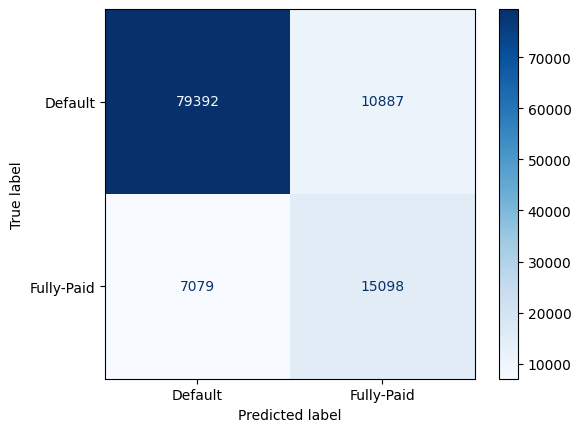

In [38]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_estimator_tuned, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.76


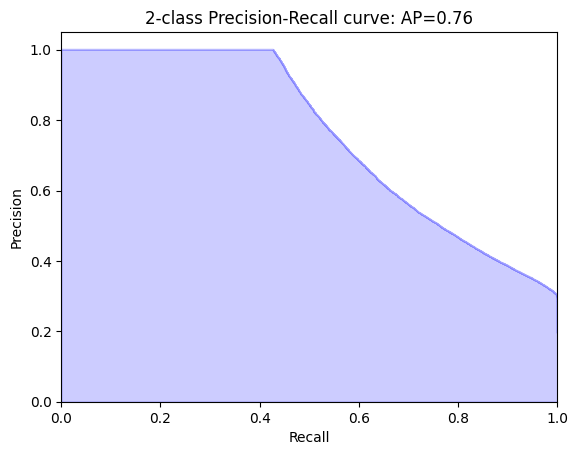

In [39]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

# **Using Preprocessed Dataset, UnderSampling Balanced, Tuning, F1 scorer**

In [48]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [49]:
rus = RandomUnderSampler(random_state=42)

In [51]:
X_train_sam, y_train_sam = rus.fit_resample(X_train, y_train)

In [52]:
print('Fully Paid:', y_train_sam.value_counts()[0], '/', round(y_train_sam.value_counts()[0]/len(y_train_sam) * 100,2), '% of the dataset')
print('Charged Off:', y_train_sam.value_counts()[1], '/',round(y_train_sam.value_counts()[1]/len(y_train_sam) * 100,2), '% of the dataset')

Fully Paid: 44217 / 50.0 % of the dataset
Charged Off: 44217 / 50.0 % of the dataset


In [55]:

# xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )
# Choose the type of classifier.

xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )



In [56]:
pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),  # Apply RandomUnderSampler to undersample the majority class
    xgb)

In [57]:
parameters = {"xgbclassifier__max_depth":range(3,10,2),
            "xgbclassifier__min_child_weight":range(1,6,2),
            "xgbclassifier__learning_rate": [0.30000012],
            "xgbclassifier__n_estimators":[100, 200]
             }

# Type of scoring used to compare parameter combinations

scorer = metrics.make_scorer(f1_score, pos_label = 1)


# Run the grid search

xgb_model = RandomizedSearchCV(pipeline, parameters, scoring = scorer, cv = 3)


#fit the GridSearch on train dataset

xgb_model = xgb_model.fit(X_train_sam, y_train_sam)


# Set the clf to the best combination of parameters

xgb_estimator_tuned = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned.fit(X_train_sam, y_train_sam)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.30000012, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=4,
                               num_parallel_tree=None, random_state=123, ...))])

In [58]:
y_train_pred = xgb_estimator_tuned.predict(X_train_sam)
y_test_pred = xgb_estimator_tuned.predict(X_test)

print_score(y_train_sam, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 81.41%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.818992      0.809441  0.814144      0.814216      0.814216
recall         0.806545      0.821743  0.814144      0.814144      0.814144
f1-score       0.812721      0.815546  0.814144      0.814133      0.814133
support    44217.000000  44217.000000  0.814144  88434.000000  88434.000000
_______________________________________________
Confusion Matrix: 
 [[35663  8554]
 [ 7882 36335]]

Test Result:
Accuracy Score: 80.13%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.943400      0.497685  0.801318       0.720542       0.855502
recall         0.800541      0.804482  0.801318       0.802511       0.801318
f1-score       0.866119      0.614942  0.801318       0.740530       0.

In [59]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [60]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6054774172049632


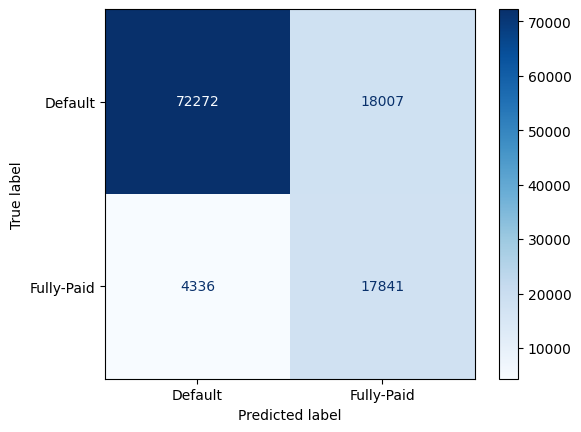

In [61]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_estimator_tuned, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


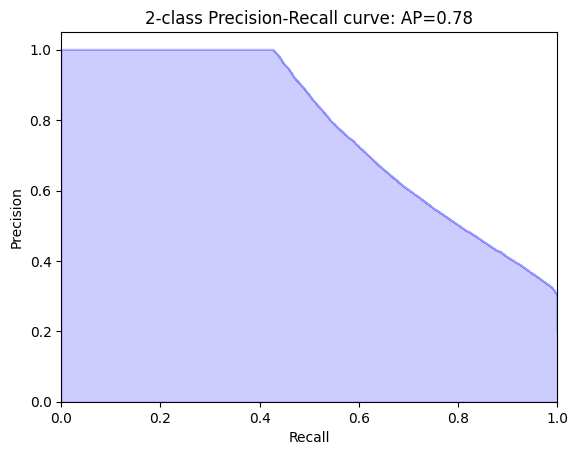

In [62]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

 # **Using Preprocessed Dataset, Imbalanced, Tuning, aucpr scorer**

In [77]:
# Choose the type of classifier.

xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )


# Grid of parameters to choose from

parameters = {'max_depth':range(3,10,2),
            'min_child_weight':range(1,6,2),
            'learning_rate': [0.30000012],
            'max_bin':[256],
            'n_estimators':[100, 200]
             }


# Type of scoring used to compare parameter combinations

# scorer = metrics.make_scorer(recall_score, pos_label = 1)
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Run the grid search

xgb_model = RandomizedSearchCV(xgb, parameters, scoring = auprc_scorer, cv = 3)


#fit the Random Search on train dataset

xgb_model = xgb_model.fit(X_train, y_train)


# Set the clf to the best combination of parameters

xgb_estimator_tuned = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30000012,
              max_bin=256, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, random_state=123, ...)

In [78]:
y_train_pred = xgb_estimator_tuned.predict(X_train)
y_test_pred = xgb_estimator_tuned.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 89.15%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.886861      0.931488  0.891476       0.909175       0.895687
recall          0.991169      0.487052  0.891476       0.739111       0.891476
f1-score        0.936119      0.639648  0.891476       0.787884       0.877489
support    179374.000000  44217.000000  0.891476  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[177790   1584]
 [ 22681  21536]]

Test Result:
Accuracy Score: 88.84%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.884941      0.919060  0.888427       0.902001       0.891670
recall         0.989699      0.476169  0.888427       0.732934       0.888427
f1-score       0.934393      0.627321  0.888427     

In [80]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [81]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6116242036543968


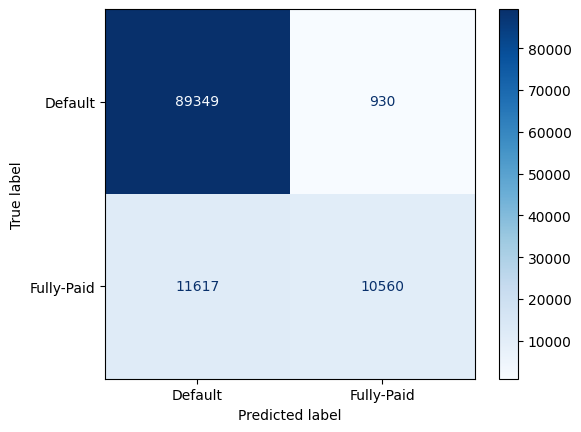

In [82]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_estimator_tuned, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


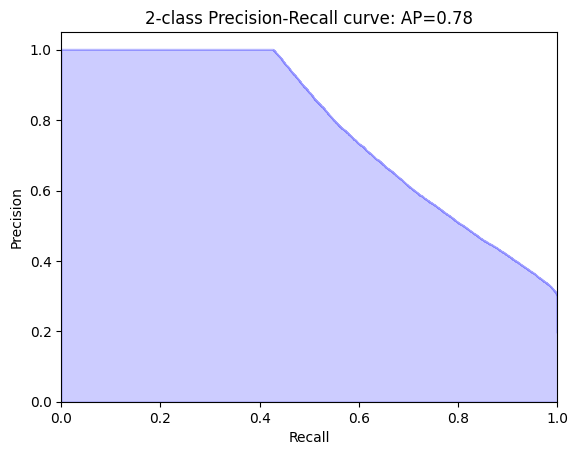

In [83]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

# **Using Preprocessed Dataset, scale_pos_weight=Balanced, Tuning, aucpr scorer**

In [41]:
from sklearn.metrics import make_scorer, average_precision_score

In [40]:
# Calculate the scale_pos_weight using the square root transformation
scale_pos_weight = float(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

In [42]:
# Choose the type of classifier.

xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr",scale_pos_weight=scale_pos_weight )


# Grid of parameters to choose from

parameters = {'max_depth':range(3,10,2),
            'min_child_weight':range(1,6,2),
            'learning_rate': [0.30000012],
            'max_bin':[256],
            'n_estimators':[100, 200]
             }


# Type of scoring used to compare parameter combinations

# scorer = metrics.make_scorer(f1_score, pos_label = 1)




auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Run the grid search

xgb_model = RandomizedSearchCV(xgb, parameters, scoring = auprc_scorer, cv = 3)


#fit the Random Search on train dataset

xgb_model = xgb_model.fit(X_train, y_train)


# Set the clf to the best combination of parameters

xgb_estimator_tuned = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30000012,
              max_bin=256, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, random_state=123, ...)

In [43]:
y_train_pred = xgb_estimator_tuned.predict(X_train)
y_test_pred = xgb_estimator_tuned.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 81.30%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.949705      0.517103  0.813047       0.733404       0.864155
recall          0.809850      0.826017  0.813047       0.817933       0.813047
f1-score        0.874220      0.636035  0.813047       0.755127       0.827117
support    179374.000000  44217.000000  0.813047  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[145266  34108]
 [  7693  36524]]

Test Result:
Accuracy Score: 80.76%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.943964      0.507696  0.807605       0.725830       0.857929
recall         0.808328      0.804662  0.807605       0.806495       0.807605
f1-score       0.870896      0.622580  0.807605     

In [44]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [47]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6146233584746814


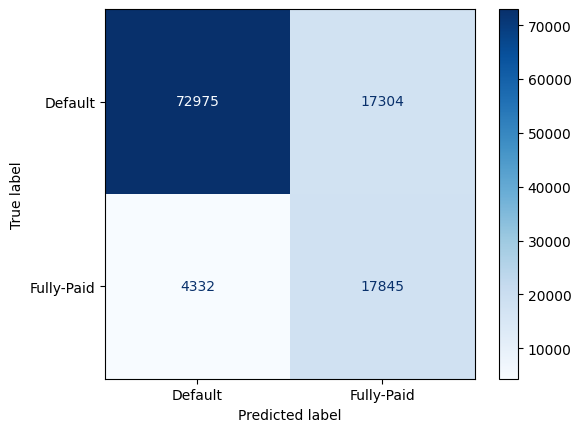

In [45]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_estimator_tuned, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


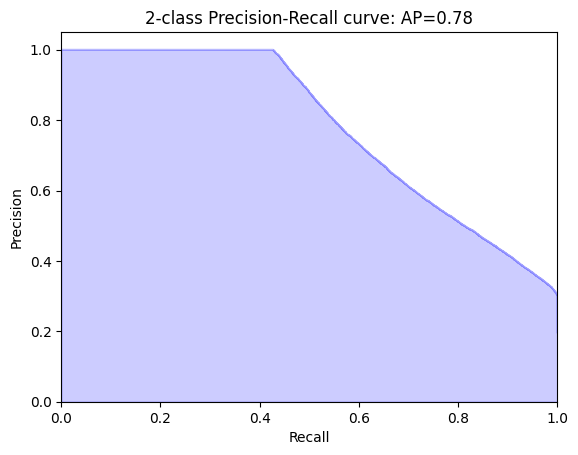

In [46]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

ss

# **Using Preprocessed Dataset, UnderSampling Balanced, Tuning, aucpr scorer**

In [63]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [64]:
rus = RandomUnderSampler(random_state=42)

In [65]:
X_train_sam, y_train_sam = rus.fit_resample(X_train, y_train)

In [66]:
print('Fully Paid:', y_train_sam.value_counts()[0], '/', round(y_train_sam.value_counts()[0]/len(y_train_sam) * 100,2), '% of the dataset')
print('Charged Off:', y_train_sam.value_counts()[1], '/',round(y_train_sam.value_counts()[1]/len(y_train_sam) * 100,2), '% of the dataset')

Fully Paid: 44217 / 50.0 % of the dataset
Charged Off: 44217 / 50.0 % of the dataset


In [67]:

# xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )
# Choose the type of classifier.

xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )



In [68]:
pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),  # Apply RandomUnderSampler to undersample the majority class
    xgb)

In [69]:
parameters = {"xgbclassifier__max_depth":range(3,10,2),
            "xgbclassifier__min_child_weight":range(1,6,2),
            "xgbclassifier__learning_rate": [0.30000012],
            "xgbclassifier__n_estimators":[100, 200]
             }

# Type of scoring used to compare parameter combinations

# scorer = metrics.make_scorer(f1_score, pos_label = 1)


auprc_scorer = make_scorer(average_precision_score, needs_proba=True)
# Run the grid search

xgb_model = RandomizedSearchCV(pipeline, parameters, scoring = auprc_scorer, cv = 3)


#fit the GridSearch on train dataset

xgb_model = xgb_model.fit(X_train_sam, y_train_sam)


# Set the clf to the best combination of parameters

xgb_estimator_tuned = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned.fit(X_train_sam, y_train_sam)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.30000012, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=4,
                               num_parallel_tree=None, random_state=123, ...))])

In [70]:
y_train_pred = xgb_estimator_tuned.predict(X_train_sam)
y_test_pred = xgb_estimator_tuned.predict(X_test)

print_score(y_train_sam, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 81.41%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.818992      0.809441  0.814144      0.814216      0.814216
recall         0.806545      0.821743  0.814144      0.814144      0.814144
f1-score       0.812721      0.815546  0.814144      0.814133      0.814133
support    44217.000000  44217.000000  0.814144  88434.000000  88434.000000
_______________________________________________
Confusion Matrix: 
 [[35663  8554]
 [ 7882 36335]]

Test Result:
Accuracy Score: 80.13%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.943400      0.497685  0.801318       0.720542       0.855502
recall         0.800541      0.804482  0.801318       0.802511       0.801318
f1-score       0.866119      0.614942  0.801318       0.740530       0.

In [71]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [75]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6054774172049632


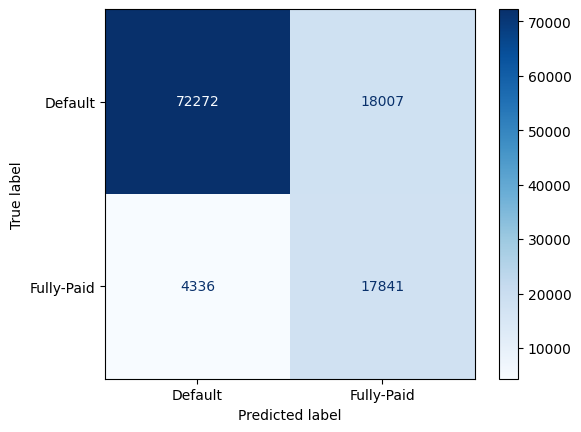

In [73]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_estimator_tuned, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)


Average precision-recall score: 0.78


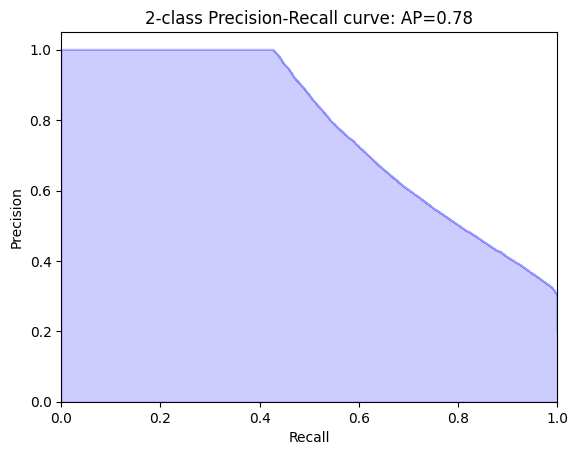

In [74]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)

# **XGBoost, Preprocessed dataset, Balanced(SMOTE)**

In [84]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [85]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to the training data only
sm = SMOTE(random_state=123)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [86]:
print("Shape of the training set: ", X_train_res.shape)

print("Shape of the test set: ", X_test.shape)

print("Percentage of classes in the training set:")

print(y_train_res.value_counts(normalize = True))

print("Percentage of classes in the test set:")

print(y_test.value_counts(normalize = True))

Shape of the training set:  (358748, 67)
Shape of the test set:  (112456, 67)
Percentage of classes in the training set:
loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64
Percentage of classes in the test set:
loan_status
0    0.802794
1    0.197206
Name: proportion, dtype: float64


In [87]:

# xgb = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )
# Choose the type of classifier.

xgb_estimator_tuned_smote = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4,eval_metric="aucpr" )



In [88]:
pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),  # Apply RandomUnderSampler to undersample the majority class
    xgb_estimator_tuned_smote)

In [89]:
parameters = {"xgbclassifier__max_depth":range(3,10,2),
            "xgbclassifier__min_child_weight":range(1,6,2),
            "xgbclassifier__learning_rate": [0.30000012],
            "xgbclassifier__n_estimators":[100, 200]
             }

# Type of scoring used to compare parameter combinations

scorer = metrics.make_scorer(f1_score, pos_label = 1)


# Run the grid search

xgb_model = RandomizedSearchCV(pipeline, parameters, scoring = scorer, cv = 3)


#fit the GridSearch on train dataset

xgb_model = xgb_model.fit(X_train_res, y_train_res)


# Set the clf to the best combination of parameters

xgb_estimator_tuned_smote = xgb_model.best_estimator_


# Fit the best algorithm to the data.

xgb_estimator_tuned_smote.fit(X_train_res, y_train_res)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.30000012, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=4,
                               num_parallel_tree=None, random_state=123, ...))])

In [90]:
y_train_pred = xgb_estimator_tuned_smote.predict(X_train_res)
y_test_pred = xgb_estimator_tuned_smote.predict(X_test)

print_score(y_train_res, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 93.56%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.892154       0.989930  0.935623       0.941042   
recall          0.991047       0.880200  0.935623       0.935623   
f1-score        0.939004       0.931846  0.935623       0.935425   
support    179374.000000  179374.000000  0.935623  358748.000000   

            weighted avg  
precision       0.941042  
recall          0.935623  
f1-score        0.935425  
support    358748.000000  
_______________________________________________
Confusion Matrix: 
 [[177768   1606]
 [ 21489 157885]]

Test Result:
Accuracy Score: 88.73%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.886873      0.891138  0.887334       0.889005       0.887714
recall         0.985345      0.488344  0.887334  

In [ ]:
from sklearn.metrics import f1_score

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Weighted Score:", f1_weighted)

F1 Weighted Score: 0.7449491672087801


In [91]:
y_pred_prob = xgb_estimator_tuned.predict_proba(X_test)[:,1]

In [92]:
ks = ks_score(y_test, y_pred_prob)
print("KS Score:", ks)

KS Score: 0.6116242036543968


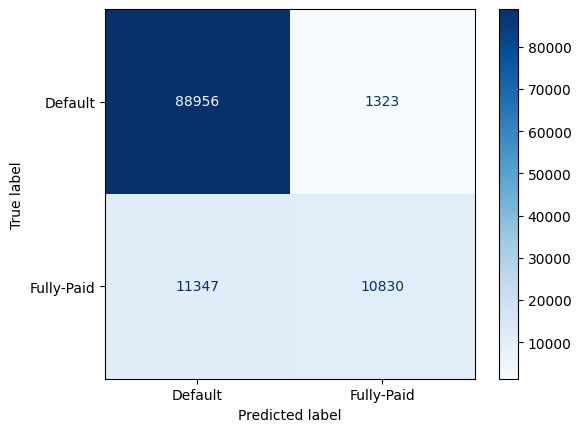

In [94]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_estimator_tuned_smote, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

Average precision-recall score: 0.78


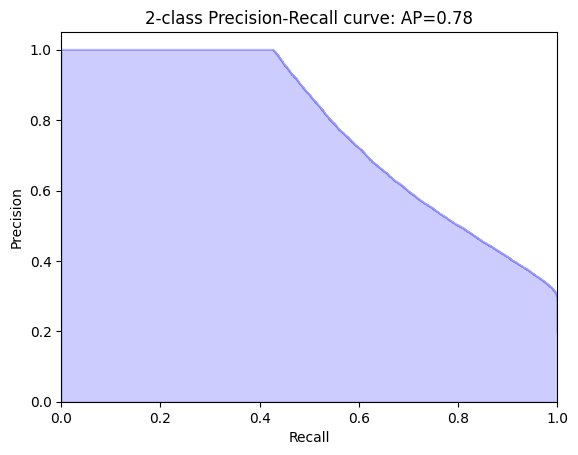

In [95]:
y_pred_prob = xgb_estimator_tuned_smote.predict_proba(X_test)[:,1]
plot_precision_recall_curve(y_test,y_pred_prob)